## 영화리뷰 분석
- NLP의 테크닉 사용

In [92]:
from keras.datasets import imdb
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, SimpleRNN, LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import set_random_seed, pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import nltk
import konlpy

In [86]:
# 데이터 로딩
# num_words = 500: 단어사전에서 빈도가 높은 500단어 까지만 사용
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=500)

In [27]:
print(x_train.shape, x_test.shape)

(25000,) (25000,)


### imdb 데이터는 이미 전처리된(데이터 수치화까지) 데이터
- 패딩 : pad_sequences로 길이만 조정해준다

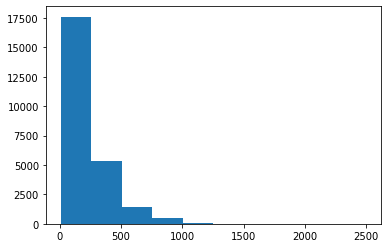

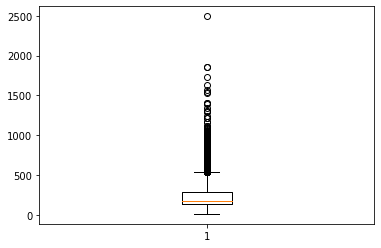

In [8]:
plt.hist([len(i) for i in x_train])
plt.show()
plt.boxplot([len(i) for i in x_train])
plt.show()

In [28]:
np.median([len(i) for i in x_train])

178.0

### 중앙값이 178이 나왔지만 메모리를 고려하여 100으로 설정

In [87]:
x_train = pad_sequences(x_train, maxlen=100)
x_test = pad_sequences(x_test, maxlen=100)

In [11]:
# ohe = OneHotEncoder()
# ohe.fit(y_train.reshape(-1,1))
# y_train = ohe.transform(y_train.reshape(-1,1))
# y_test = ohe.transform(y_test.reshape(-1,1))
# y_train = y_train.toarray()
# y_test = y_test.toarray()

In [30]:
x_train.max()

499

In [31]:
x_train = to_categorical(x_train)
x_test = to_categorical(x_test)

In [32]:
x_train.shape, x_test.shape

((25000, 100, 500), (25000, 100, 500))

In [88]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

### 모델
- 영화 리뷰 데이터 학습 후 사용자가 입력하는 리뷰가 긍정/부정 분류
- 학습 모델 : RNN 순환신경망
- 입력 : (100,500)
- 출력 : 1 -> 이진 분류(sigmoid)

In [70]:
# 모델 구성
md = Sequential()
md.add(SimpleRNN(units=30, input_shape=(100,500), recurrent_dropout= 0.3 ))
md.add(Dense(1, activation='sigmoid'))
md.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 30)                15930     
                                                                 
 dense_9 (Dense)             (None, 1)                 31        
                                                                 
Total params: 15,961
Trainable params: 15,961
Non-trainable params: 0
_________________________________________________________________


In [41]:
x_train.shape, y_train.shape

((20000, 100, 500), (20000,))

### 모델 생성
- 손실함수, 최적화방법, 평가항목 -> compile()
### 학습
- epoch마다 검증 진행 : validation_data, validation_split
- 학습 중 이벤트 처리 : callbacks
- 학습 진행 내용 조절 : verbose
- 학습 횟수 조절 : epochs
- 배치사이즈 조절 : batch_size
- RNN다음에 RNN올 때 : return_sequences 

In [72]:
# 모델 생성 및 학습
from keras.optimizers import RMSprop, Nadam
nadam = Nadam()
rmsprop = RMSprop(learning_rate=0.0001, momentum=0.3)
md.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model_rmsprop.h5', monitor='val_loss', save_best_only=True)
history = md.fit(x_train, y_train.reshape(-1,1), epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
625/625 [==============================] - 11s 17ms/step - loss: 0.6146 - accuracy: 0.6676 - val_loss: 0.7563 - val_accuracy: 0.5972
Epoch 2/100
625/625 [==============================] - 11s 18ms/step - loss: 0.6051 - accuracy: 0.6733 - val_loss: 0.6818 - val_accuracy: 0.6278
Epoch 3/100
625/625 [==============================] - 12s 19ms/step - loss: 0.5963 - accuracy: 0.6846 - val_loss: 0.7268 - val_accuracy: 0.6250
Epoch 4/100
625/625 [==============================] - 11s 18ms/step - loss: 0.5865 - accuracy: 0.6953 - val_loss: 0.6820 - val_accuracy: 0.6494
Epoch 5/100
625/625 [==============================] - 12s 19ms/step - loss: 0.5779 - accuracy: 0.7039 - val_loss: 0.6951 - val_accuracy: 0.6600
Epoch 6/100
625/625 [==============================] - 11s 18ms/step - loss: 0.5698 - accuracy: 0.7118 - val_loss: 0.7150 - val_accuracy: 0.6568
Epoch 7/100
625/625 [==============================] - 12s 18ms/step - loss: 0.5585 - accuracy: 0.7212 - val_loss: 0.5533 - val_ac

In [73]:
# 모델 평가
md.evaluate(x_test, y_test.reshape(-1,1))

782/782 [==============================] - 7s 8ms/step - loss: 0.4712 - accuracy: 0.7856


[0.4712427258491516, 0.7856400012969971]

In [78]:
# 모델 구성
md = Sequential()
md.add(SimpleRNN(units=9, input_shape=(100,500), recurrent_dropout= 0.3 , return_sequences=True))
md.add(Dense(1, activation='sigmoid'))
md.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 9)                 4590      
                                                                 
 dense_12 (Dense)            (None, 1)                 10        
                                                                 
Total params: 4,600
Trainable params: 4,600
Non-trainable params: 0
_________________________________________________________________


In [80]:
# 모델 생성 및 학습
md.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', save_best_only=True)
history = md.fit(x_train, y_train.reshape(-1,1), epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
625/625 [==============================] - 11s 16ms/step - loss: 0.5354 - accuracy: 0.7467 - val_loss: 0.5084 - val_accuracy: 0.7628
Epoch 2/100
625/625 [==============================] - 10s 15ms/step - loss: 0.5384 - accuracy: 0.7423 - val_loss: 0.5319 - val_accuracy: 0.7510
Epoch 3/100
625/625 [==============================] - 11s 17ms/step - loss: 0.5371 - accuracy: 0.7452 - val_loss: 0.5086 - val_accuracy: 0.7652
Epoch 4/100
625/625 [==============================] - 11s 17ms/step - loss: 0.5464 - accuracy: 0.7384 - val_loss: 0.5669 - val_accuracy: 0.7278
Epoch 5/100
625/625 [==============================] - 11s 17ms/step - loss: 0.5684 - accuracy: 0.7133 - val_loss: 0.5277 - val_accuracy: 0.7494
Epoch 6/100
625/625 [==============================] - 11s 17ms/step - loss: 0.5411 - accuracy: 0.7384 - val_loss: 0.6020 - val_accuracy: 0.6664
Epoch 7/100
625/625 [==============================] - 11s 18ms/step - loss: 0.5478 - accuracy: 0.7325 - val_loss: 0.5820 - val_ac

### RNN Model test 베스트 값 : 0.7856

### Embedding RNN Model
- One-Hot Encoding 입력 데이터의 많은 메모리 소모에 대한 문제 해결
- 토큰을 밀집형태의 벡터로 변경 -> word Embedding
- Embedding Layer 적용
    - 입력 차원 : 토큰의 크기(단어사전의 크기)
    - 출력 차원 : 줄여서 생성하는 벡터크기 (내가 임의로 지정하는 하이퍼파라미터)
    - 입력층일 경우, input_length = 타임스탬프(즉, 하나의 문장을 구성하는 토큰 수)

In [89]:
# 모델 구성
from keras.layers import Embedding
md2 = Sequential()
# Embedding : OneHotEncoding의 거대한 데이터 -> 축소
md2.add(Embedding(500, 20, input_length=100))  
md2.add(SimpleRNN(10))
md2.add(Dense(1, activation='sigmoid'))
md2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 20)           10000     
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 10)                310       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 10,321
Trainable params: 10,321
Non-trainable params: 0
_________________________________________________________________


In [90]:
x_train.shape

(20000, 100)

In [91]:
md2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', save_best_only=True)
history = md2.fit(x_train, y_train.reshape(-1,1), epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
625/625 [==============================] - 8s 12ms/step - loss: 0.6840 - accuracy: 0.5434 - val_loss: 0.6754 - val_accuracy: 0.5560
Epoch 2/100
625/625 [==============================] - 7s 12ms/step - loss: 0.6258 - accuracy: 0.6434 - val_loss: 0.5816 - val_accuracy: 0.7008
Epoch 3/100
625/625 [==============================] - 7s 12ms/step - loss: 0.5407 - accuracy: 0.7324 - val_loss: 0.5612 - val_accuracy: 0.7120
Epoch 4/100
625/625 [==============================] - 7s 12ms/step - loss: 0.4889 - accuracy: 0.7753 - val_loss: 0.5374 - val_accuracy: 0.7350
Epoch 5/100
625/625 [==============================] - 7s 12ms/step - loss: 0.4944 - accuracy: 0.7707 - val_loss: 0.5422 - val_accuracy: 0.7402
Epoch 6/100
625/625 [==============================] - 7s 12ms/step - loss: 0.4588 - accuracy: 0.7940 - val_loss: 0.5450 - val_accuracy: 0.7470
Epoch 7/100
625/625 [==============================] - 7s 12ms/step - loss: 0.4318 - accuracy: 0.8095 - val_loss: 0.5465 - val_accuracy:

In [93]:
# 모듈 구성
from keras.layers import Embedding
md2 = Sequential()

md2.add(Embedding(500, 20, input_length=100))  
md2.add(LSTM(10))
md2.add(Dense(1, activation='sigmoid'))
md2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 20)           10000     
                                                                 
 lstm (LSTM)                 (None, 10)                1240      
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [94]:
md2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=8)
mcp = ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', save_best_only=True)
history = md2.fit(x_train, y_train.reshape(-1,1), epochs=100, validation_data=(x_val, y_val), callbacks=[es, mcp])

Epoch 1/100
625/625 [==============================] - 13s 18ms/step - loss: 0.5396 - accuracy: 0.7282 - val_loss: 0.4789 - val_accuracy: 0.7802
Epoch 2/100
625/625 [==============================] - 11s 18ms/step - loss: 0.4385 - accuracy: 0.7980 - val_loss: 0.4446 - val_accuracy: 0.7870
Epoch 3/100
625/625 [==============================] - 12s 20ms/step - loss: 0.4196 - accuracy: 0.8099 - val_loss: 0.4479 - val_accuracy: 0.7816
Epoch 4/100
625/625 [==============================] - 12s 19ms/step - loss: 0.4093 - accuracy: 0.8127 - val_loss: 0.4385 - val_accuracy: 0.7958
Epoch 5/100
625/625 [==============================] - 12s 19ms/step - loss: 0.3988 - accuracy: 0.8174 - val_loss: 0.4371 - val_accuracy: 0.7882
Epoch 6/100
625/625 [==============================] - 13s 20ms/step - loss: 0.3934 - accuracy: 0.8180 - val_loss: 0.4471 - val_accuracy: 0.7916
Epoch 7/100
625/625 [==============================] - 13s 20ms/step - loss: 0.3886 - accuracy: 0.8205 - val_loss: 0.4395 - val_ac

In [95]:
# 모델 평가
md2.evaluate(x_test, y_test.reshape(-1,1))

782/782 [==============================] - 5s 6ms/step - loss: 0.4491 - accuracy: 0.8081


[0.4491218626499176, 0.8081200122833252]

### LSTM 성능: 0.8081 로 우수